In [185]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, r2_score, explained_variance_score

In [146]:
def get_raw_df():
    return pd.read_csv(r"C:\Users\91910\Desktop\IIT_Kanpur\Semester6\MSE643A\Project\bandGap\dielectric_constant_data.csv")

def get_propsFromStruct(df): #returns len, angles and periodic properties of a crystal structure for all compounds
    structure_arr = []

    for struct in df['structure']:
        finalStruct_arr = []
        modLen_arr = []
        modAngl_arr = []
        #modPerio_arr = []
        split_arr = struct.split('\n')
        len_arr = split_arr[2].split()[2:]
        angl_arr = split_arr[3].split()[1:]
        #perio_arr = split_arr[4].split()[2:]
        for i in range(3):
            modLen_arr.append(float(len_arr[i]))
            modAngl_arr.append(float(angl_arr[i]))
        for ele in modLen_arr:
            finalStruct_arr.append(ele)
        for ele in modAngl_arr:
            finalStruct_arr.append(ele)
#         for ele in perio_arr:
#             finalStruct_arr.append(ele)
        structure_arr.append(finalStruct_arr)
        
    return np.array(structure_arr)

def transform_raw_e_electronic(df): #transforms e_electronic into model readable values
    res = []
    for tensor_per_struct in df['e_electronic']:
        tensor_split = tensor_per_struct[2:-2].split(',')
        for i in range(len(tensor_split)):
            if (i==2 or i==5):
                tensor_split[i] = tensor_split[i].strip()[:-1]
            elif (i==3 or i==6):
                tensor_split[i] = tensor_split[i].strip()[1:]
        for j in range(len(tensor_split)):
            tensor_split[j] = float(tensor_split[j])
        res.append(tensor_split)
    return np.array(res)

def transform_raw_e_total(df): #transforms e_total into model readable values
    res = []
    for tensor_per_struct in df['e_total']:
        tensor_split = tensor_per_struct[2:-2].split(',')
        for i in range(len(tensor_split)):
            if (i==2 or i==5):
                tensor_split[i] = tensor_split[i].strip()[:-1]
            elif (i==3 or i==6):
                tensor_split[i] = tensor_split[i].strip()[1:]
        for j in range(len(tensor_split)):
            tensor_split[j] = float(tensor_split[j])
        res.append(tensor_split)
    return np.array(res)

def get_mod_df():
    raw_df = get_raw_df()
    mod_df = raw_df.copy()
    mod_df.drop(raw_df.columns[[0,1,2,6,8,9,14,15,16]], inplace= True, axis= 1)
    transformed_e_electronic = transform_raw_e_electronic(raw_df)
    transformed_e_total = transform_raw_e_total(raw_df)
    propsFromStruct_arr = get_propsFromStruct(raw_df)
    for i in range(9):
        mod_df['e_e_' + str(i)] = transformed_e_electronic[:, i]
    for i in range(9):
        mod_df['e_t_' + str(i)] = transformed_e_total[:, i]
    mod_df['len_a'] = propsFromStruct_arr[:,0]
    mod_df['len_b'] = propsFromStruct_arr[:,1]
    mod_df['len_c'] = propsFromStruct_arr[:,2]
    mod_df['angl_alpha'] = propsFromStruct_arr[:,3]
    mod_df['angl_beta'] = propsFromStruct_arr[:,4]
    mod_df['angl_gamma'] = propsFromStruct_arr[:,5]
    #below are excluded as they are true for all the compounds
#     mod_df['prd_p'] = propsFromStruct_arr[:,6]
#     mod_df['prd_b'] = propsFromStruct_arr[:,7]
#     mod_df['prd_c'] = propsFromStruct_arr[:,8]
    return mod_df

def transform_boolData(df, col_name): #1d array must be given
    le = LabelEncoder()
    df[col_name] = le.fit_transform(df[col_name])
    
def normal_split(df, test_size, shuffle):
    X = df.drop('band_gap', axis=1)
    y = df['band_gap']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42, shuffle=shuffle)
    
    return (X_train, X_test, y_train, y_test)

def plot_distribution(df, col_name, bin_num):
    sns.histplot(df[col_name], kde=True, bins=bin_num)
    plt.show()

def detectOutliers_IQR():
    q1 = mod_df['band_gap'].quantile(0.25)
    q3 = mod_df['band_gap'].quantile(0.75)
    print('Q1 is: ', q1)
    print('Q3 is: ', q3)
    iqr = q3 - q1
    print('Outlier above Q3:')
    print(mod_df[mod_df['band_gap'] > q3 + 1.5 * iqr]['band_gap'])
    print()
    print('Outliers below Q1:')
    print(mod_df[mod_df['band_gap'] < q1 - 1.5 * iqr]['band_gap'])
    outliers_above_Q3 = mod_df[mod_df['band_gap'] > q3 + 1.5 * iqr].index
    outliers_below_Q1 = mod_df[mod_df['band_gap'] < q1 - 1.5 * iqr].index
    return (np.array(outliers_above_Q3), np.array(outliers_below_Q1))
    
def removeOutliers_IQR():
    outliers_above_Q3, outliers_below_Q1 = detectOutliers_IQR()
    all_outlier_indexes = np.concatenate((outliers_below_Q1, outliers_above_Q3))
    mod_df_without_outliers = mod_df.drop(all_outlier_indexes)
    return mod_df_without_outliers

def scale_features(df_withoutBoolVals):
    scaler = StandardScaler()
    scaled_df_withoutBoolVals = scaler.fit_transform(df_withoutBoolVals)
    return scaled_df_withoutBoolVals

def evaluate_metrics(y_test, y_preds):
    r2 = r2_score(y_test, y_preds)
    mae = mean_absolute_error(y_test, y_preds)
    evs = explained_variance_score(y_test, y_preds)

    print('r2 score is ', r2)
    print('mean absolute error is ', mae)
    print('explained variance score is ', evs)

In [147]:
mod_df = get_mod_df()
transform_boolData(mod_df, 'pot_ferroelectric')

mod_df

,nsites,space_group,volume,band_gap,n,poly_electronic,poly_total,pot_ferroelectric,e_e_0,e_e_1,...,e_t_5,e_t_6,e_t_7,e_t_8,len_a,len_b,len_c,angl_alpha,angl_beta,angl_gamma
0,3,225,159.501208,1.88,1.86,3.44,6.23,0,3.441158,-3.097000e-05,...,2.481000e-05,-0.000095,2.175000e-05,6.235207,6.087322,6.087322,6.087323,60.000003,60.000002,59.999999
1,3,166,84.298097,3.52,1.78,3.16,6.73,0,3.346884,-4.498543e-02,...,-9.046643e-01,-1.463589,-9.046600e-01,3.945366,6.710024,6.710024,6.710023,34.019895,34.019897,34.019896
2,3,164,108.335875,1.17,2.23,4.97,10.64,0,5.543085,-5.280000e-06,...,4.435100e-04,0.000123,4.420300e-04,4.315681,4.158086,4.158086,7.235270,90.000000,90.000000,120.000001
3,4,186,88.162562,1.12,2.65,7.04,17.99,0,7.093167,7.990000e-06,...,2.064269e-02,-0.008708,1.761772e-02,20.396643,4.132865,4.132865,5.960067,90.000000,90.000000,119.999995
4,6,136,82.826401,2.87,1.53,2.35,7.12,0,2.423962,7.452000e-05,...,1.344158e-02,0.001279,1.441676e-02,7.459124,3.354588,4.968952,4.968952,90.000000,90.000000,90.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1051,7,111,212.493121,0.87,2.77,7.67,11.76,1,7.748968,0.000000e+00,...,0.000000e+00,0.000000,0.000000e+00,11.562826,5.912075,5.912075,6.079460,90.000000,90.000000,90.000000
1052,8,194,220.041363,3.60,2.00,3.99,7.08,1,4.405044,6.100000e-07,...,-1.000000e-08,0.000000,-1.000000e-08,3.696193,4.137833,4.137856,14.839681,90.000000,90.000000,119.999810
1053,4,216,73.882306,0.14,14.58,212.61,232.60,1,212.607502,-1.843000e-05,...,1.830120e-03,0.002588,1.830120e-03,232.596394,4.709974,4.709973,4.709974,59.999995,59.999999,60.000000
1054,5,221,177.269065,0.21,2.53,6.41,22.44,1,6.405117,0.000000e+00,...,0.000000e+00,0.000000,0.000000e+00,22.438270,5.617516,5.617516,5.617516,90.000000,90.000000,90.000000


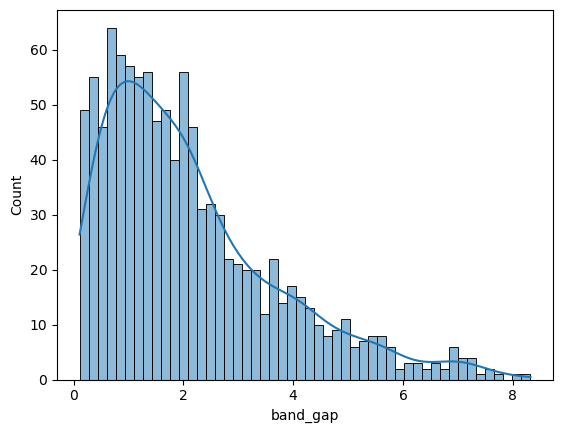

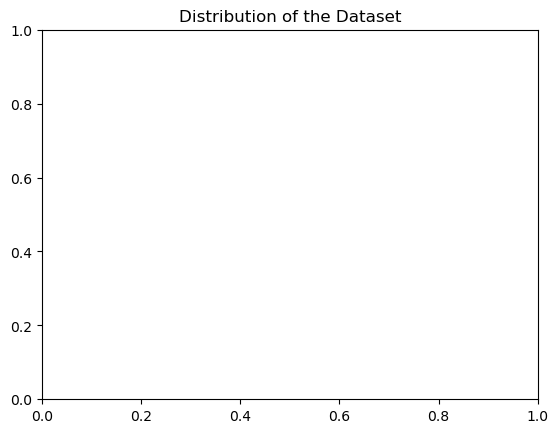

In [204]:
#analysing distribution curve for band_gap values for outlier detection
plot_distribution(mod_df, 'band_gap', 50)

plt.title('Distribution of the Dataset')

plt.show()

In [149]:
mod_df_without_outliers = removeOutliers_IQR()

mod_df_without_outliers

Q1 is:  0.89
Q3 is:  2.885
Outlier above Q3:
47      6.85
121     7.72
129     6.33
154     7.09
160     8.09
166     6.63
167     7.60
175     6.56
188     6.30
229     6.07
359     8.32
391     6.79
410     6.90
429     6.41
430     6.94
431     6.95
481     7.13
507     7.22
599     7.28
601     6.81
646     5.94
667     7.01
717     5.97
736     6.03
841     6.88
895     6.12
904     6.61
920     7.02
934     6.40
952     6.23
985     7.54
990     7.26
994     6.99
1034    7.23
1047    7.42
Name: band_gap, dtype: float64

Outliers below Q1:
Series([], Name: band_gap, dtype: float64)


,nsites,space_group,volume,band_gap,n,poly_electronic,poly_total,pot_ferroelectric,e_e_0,e_e_1,...,e_t_5,e_t_6,e_t_7,e_t_8,len_a,len_b,len_c,angl_alpha,angl_beta,angl_gamma
0,3,225,159.501208,1.88,1.86,3.44,6.23,0,3.441158,-3.097000e-05,...,2.481000e-05,-0.000095,2.175000e-05,6.235207,6.087322,6.087322,6.087323,60.000003,60.000002,59.999999
1,3,166,84.298097,3.52,1.78,3.16,6.73,0,3.346884,-4.498543e-02,...,-9.046643e-01,-1.463589,-9.046600e-01,3.945366,6.710024,6.710024,6.710023,34.019895,34.019897,34.019896
2,3,164,108.335875,1.17,2.23,4.97,10.64,0,5.543085,-5.280000e-06,...,4.435100e-04,0.000123,4.420300e-04,4.315681,4.158086,4.158086,7.235270,90.000000,90.000000,120.000001
3,4,186,88.162562,1.12,2.65,7.04,17.99,0,7.093167,7.990000e-06,...,2.064269e-02,-0.008708,1.761772e-02,20.396643,4.132865,4.132865,5.960067,90.000000,90.000000,119.999995
4,6,136,82.826401,2.87,1.53,2.35,7.12,0,2.423962,7.452000e-05,...,1.344158e-02,0.001279,1.441676e-02,7.459124,3.354588,4.968952,4.968952,90.000000,90.000000,90.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1051,7,111,212.493121,0.87,2.77,7.67,11.76,1,7.748968,0.000000e+00,...,0.000000e+00,0.000000,0.000000e+00,11.562826,5.912075,5.912075,6.079460,90.000000,90.000000,90.000000
1052,8,194,220.041363,3.60,2.00,3.99,7.08,1,4.405044,6.100000e-07,...,-1.000000e-08,0.000000,-1.000000e-08,3.696193,4.137833,4.137856,14.839681,90.000000,90.000000,119.999810
1053,4,216,73.882306,0.14,14.58,212.61,232.60,1,212.607502,-1.843000e-05,...,1.830120e-03,0.002588,1.830120e-03,232.596394,4.709974,4.709973,4.709974,59.999995,59.999999,60.000000
1054,5,221,177.269065,0.21,2.53,6.41,22.44,1,6.405117,0.000000e+00,...,0.000000e+00,0.000000,0.000000e+00,22.438270,5.617516,5.617516,5.617516,90.000000,90.000000,90.000000


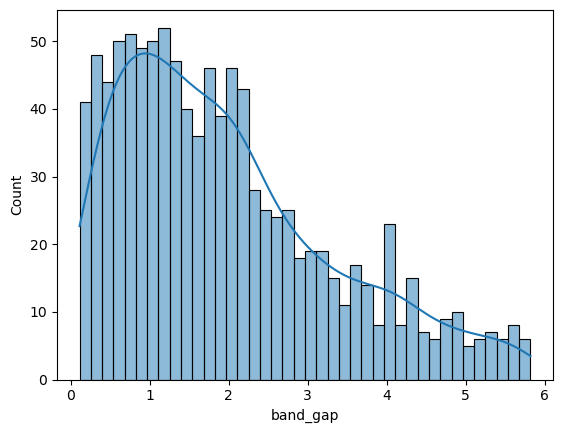

In [150]:
plot_distribution(mod_df_without_outliers, 'band_gap', 40)

In [151]:
X_train_without_outliers_df, X_test_without_outliers_df, y_train_without_outliers, y_test_without_outliers = normal_split(mod_df_without_outliers, 0.3, True)

print(X_train_without_outliers_df.shape)
print(X_test_without_outliers_df.shape)

(714, 31)
(307, 31)


In [152]:
X_train_without_outliers_df

,nsites,space_group,volume,n,poly_electronic,poly_total,pot_ferroelectric,e_e_0,e_e_1,e_e_2,...,e_t_5,e_t_6,e_t_7,e_t_8,len_a,len_b,len_c,angl_alpha,angl_beta,angl_gamma
237,4,186,138.261812,2.34,5.49,8.00,0,5.450427,-0.000003,0.000094,...,-2.689000e-04,-2.158180e-03,-9.587000e-05,8.331210,4.610881,4.610881,7.509375,90.000000,90.000000,119.999995
899,4,166,51.804297,1.98,3.94,11.07,1,4.183787,-0.044564,-0.249530,...,-7.208471e-01,-1.181479e+00,-7.208471e-01,8.535944,5.854470,5.854470,5.854470,32.601100,32.601093,32.601104
370,12,14,273.845771,4.99,24.86,34.62,0,27.282973,-0.000352,-0.000463,...,-4.588760e-01,-1.087330e-03,-4.588930e-01,33.595183,6.639613,6.693588,6.794752,114.927750,90.000000,90.000000
837,5,164,107.381717,3.79,14.40,24.27,1,15.252582,0.000002,0.000000,...,-6.220000e-06,-7.000000e-08,-6.220000e-06,26.214948,4.196779,4.196779,7.039917,90.000000,90.000000,119.999996
185,14,166,103.448872,2.40,5.75,6.40,0,5.689596,0.114977,0.258814,...,-6.330480e-03,-8.677790e-03,-6.331180e-03,6.394107,5.153484,5.153483,5.153483,63.106205,63.106212,63.106203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,4,71,153.747367,1.68,2.84,5.33,0,2.757778,0.054340,-0.043389,...,-2.771576e-01,5.224950e-03,-2.771550e-01,5.281495,5.076757,6.134352,6.134352,68.337047,65.556387,65.556393
280,12,36,201.898544,1.48,2.18,3.16,1,2.139360,0.062497,0.000949,...,-9.223050e-03,-5.095270e-03,-8.787570e-03,3.367814,5.039690,5.039689,7.995674,90.000000,90.000000,96.177881
885,6,129,187.083862,1.96,3.84,9.70,1,3.849121,0.000000,0.000000,...,-5.000000e-08,-5.000000e-08,-5.000000e-08,9.617859,4.843046,4.843046,7.976257,90.000000,90.000000,90.000000
451,10,36,233.902616,2.74,7.49,14.24,1,10.781270,0.000000,0.000000,...,-6.610000e-05,-2.519400e-04,-6.610000e-05,14.148985,3.750502,5.758383,11.454838,90.000000,90.000000,109.005314


In [153]:
y_train_without_outliers

237    2.36
899    1.91
370    0.49
837    0.39
185    1.85
       ... 
107    1.70
280    3.44
885    2.41
451    0.86
103    0.26
Name: band_gap, Length: 714, dtype: float64

In [154]:
X_train_no_outliers_withoutBoolVals_df = X_train_without_outliers_df.drop('pot_ferroelectric', axis=1)
X_test_no_outliers_withoutBoolVals_df = X_test_without_outliers_df.drop('pot_ferroelectric', axis=1)

scaled_X_train_no_outliers_withoutBoolVals = scale_features(X_train_no_outliers_withoutBoolVals_df)
scaled_X_test_no_outliers_withoutBoolVals = scale_features(X_test_no_outliers_withoutBoolVals_df)

scaled_X_train_no_outliers_withoutBoolVals_df = pd.DataFrame(scaled_X_train_no_outliers_withouBoolVals, columns= X_train_no_outliers_withoutBoolVals_df.columns)
scaled_X_test_no_outliers_withoutBoolVals_df = pd.DataFrame(scaled_X_test_no_outliers_withouBoolVals, columns= X_test_no_outliers_withoutBoolVals_df.columns)

In [173]:
scaled_y_train_without_outliers = scale_features(np.array(y_train_without_outliers).reshape(len(y_train_without_outliers), 1))
scaled_y_test_without_outliers = scale_features(np.array(y_test_without_outliers).reshape(len(y_test_without_outliers), 1))

scaled_y_train_without_outliers = scaled_y_train_without_outliers.flatten()
scaled_y_test_without_outliers = scaled_y_test_without_outliers.flatten()

scaled_y_train_without_outliers

array([ 0.32513945, -0.01194972, -1.07565334, -1.15056205, -0.05689495,
       -0.95579941,  0.15284943, -0.01194972,  0.81204604,  0.90193648,
       -0.16176713,  2.49749191,  0.18281291,  0.16783117,  1.78585921,
       -0.23667584,  0.11539508, -1.23296162,  0.20528552, -0.91085419,
       -1.21797988, -0.58874675,  0.84200952, -0.76103678,  0.36259381,
        0.57233818, -0.58874675, -0.26663932,  0.22775814,  1.02928128,
        1.98062184, -1.0606716 ,  0.82702778, -0.52132892, -0.46889283,
       -0.83594548,  0.2876851 , -0.70860068,  0.4899386 , -0.69361894,
       -1.08314421, -0.94081767, -0.49136544, -0.18423974,  1.68847789,
       -1.27041597,  1.00680867, -0.03442233,  0.10790421,  0.91691823,
       -0.50634718, -0.71609155,  0.6172834 , -0.38649325,  0.91691823,
        0.5423747 ,  2.16040274,  0.31764858, -0.53631066, -0.91834506,
        0.01052289,  0.56484731, -0.50634718,  1.39633394, -1.22547075,
       -0.32656629,  2.41509234, -0.97078115, -0.91085419,  2.25

In [155]:
scaled_X_train_no_outliers_withoutBoolVals_df

,nsites,space_group,volume,n,poly_electronic,poly_total,e_e_0,e_e_1,e_e_2,e_e_3,...,e_t_5,e_t_6,e_t_7,e_t_8,len_a,len_b,len_c,angl_alpha,angl_beta,angl_gamma
0,-1.076768,0.697908,-0.317402,-0.098397,-0.130456,-0.334691,-0.134358,-0.060544,-0.003777,-0.060814,...,0.068363,0.016798,0.068609,-0.311354,-0.429403,-0.588963,0.154232,0.331389,0.348954,1.252428
1,-1.076768,0.401641,-1.202851,-0.413560,-0.240977,-0.185790,-0.204760,-0.338409,-0.997085,-0.338592,...,-1.357799,-1.800957,-1.357891,-0.299729,0.293422,0.114954,-0.471444,-2.252645,-2.272490,-2.043381
2,1.341831,-1.849988,1.071172,2.221554,1.250692,0.956435,1.079128,-0.062720,-0.005992,-0.060171,...,-0.839308,0.018448,-0.839435,1.123120,0.749780,0.589925,-0.115948,1.453608,0.348954,0.121129
3,-0.774443,0.372014,-0.633658,1.171010,0.504858,0.454438,0.410461,-0.060513,-0.004150,-0.060791,...,0.068883,0.020124,0.068787,0.704075,-0.670096,-0.823359,-0.023258,0.331389,0.348954,1.252428
4,1.946481,0.401641,-0.673936,-0.045869,-0.111918,-0.412295,-0.121064,0.656417,1.025730,0.655898,...,0.056366,0.006749,0.056268,-0.421341,-0.114020,-0.281830,-0.736468,-0.879339,-0.879302,-0.893035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709,-1.076768,-1.005627,-0.158808,-0.676196,-0.319411,-0.464192,-0.284019,0.278313,-0.176805,0.277872,...,-0.479652,0.028178,-0.479742,-0.484515,-0.158616,0.273377,-0.365628,-0.643853,-0.767401,-0.800638
710,1.341831,-1.524095,0.334330,-0.851286,-0.366471,-0.569441,-0.318392,0.329174,-0.000373,0.328823,...,0.050641,0.012270,0.051407,-0.593173,-0.180161,-0.346242,0.338089,0.331389,0.348954,0.354097
711,-0.472118,-0.146453,0.182606,-0.431069,-0.248107,-0.252238,-0.223361,-0.060526,-0.004150,-0.060804,...,0.068895,0.020124,0.068799,-0.238299,-0.294459,-0.457549,0.330748,0.331389,0.348954,0.121129
712,0.737181,-1.524095,0.662097,0.251785,0.012151,-0.032038,0.161939,-0.060526,-0.004150,-0.060804,...,0.068764,0.019736,0.068668,0.018976,-0.929490,0.060565,1.645907,0.331389,0.348954,0.837819


In [157]:
X_train_without_outliers_df = X_train_without_outliers_df.reset_index()
X_test_without_outliers_df = X_test_without_outliers_df.reset_index()
scaled_X_train_no_outliers_df = scaled_X_train_no_outliers_withoutBoolVals_df.copy()
scaled_X_test_no_outliers_df = scaled_X_test_no_outliers_withoutBoolVals_df.copy()
scaled_X_train_no_outliers_df['pot_ferroelectric'] = X_train_without_outliers_df['pot_ferroelectric']
scaled_X_test_no_outliers_df['pot_ferroelectric'] = X_test_without_outliers_df['pot_ferroelectric']

,nsites,space_group,volume,n,poly_electronic,poly_total,e_e_0,e_e_1,e_e_2,e_e_3,...,e_t_6,e_t_7,e_t_8,len_a,len_b,len_c,angl_alpha,angl_beta,angl_gamma,pot_ferroelectric
0,-1.076768,0.697908,-0.317402,-0.098397,-0.130456,-0.334691,-0.134358,-0.060544,-0.003777,-0.060814,...,0.016798,0.068609,-0.311354,-0.429403,-0.588963,0.154232,0.331389,0.348954,1.252428,0
1,-1.076768,0.401641,-1.202851,-0.413560,-0.240977,-0.185790,-0.204760,-0.338409,-0.997085,-0.338592,...,-1.800957,-1.357891,-0.299729,0.293422,0.114954,-0.471444,-2.252645,-2.272490,-2.043381,1
2,1.341831,-1.849988,1.071172,2.221554,1.250692,0.956435,1.079128,-0.062720,-0.005992,-0.060171,...,0.018448,-0.839435,1.123120,0.749780,0.589925,-0.115948,1.453608,0.348954,0.121129,0
3,-0.774443,0.372014,-0.633658,1.171010,0.504858,0.454438,0.410461,-0.060513,-0.004150,-0.060791,...,0.020124,0.068787,0.704075,-0.670096,-0.823359,-0.023258,0.331389,0.348954,1.252428,1
4,1.946481,0.401641,-0.673936,-0.045869,-0.111918,-0.412295,-0.121064,0.656417,1.025730,0.655898,...,0.006749,0.056268,-0.421341,-0.114020,-0.281830,-0.736468,-0.879339,-0.879302,-0.893035,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709,-1.076768,-1.005627,-0.158808,-0.676196,-0.319411,-0.464192,-0.284019,0.278313,-0.176805,0.277872,...,0.028178,-0.479742,-0.484515,-0.158616,0.273377,-0.365628,-0.643853,-0.767401,-0.800638,0
710,1.341831,-1.524095,0.334330,-0.851286,-0.366471,-0.569441,-0.318392,0.329174,-0.000373,0.328823,...,0.012270,0.051407,-0.593173,-0.180161,-0.346242,0.338089,0.331389,0.348954,0.354097,1
711,-0.472118,-0.146453,0.182606,-0.431069,-0.248107,-0.252238,-0.223361,-0.060526,-0.004150,-0.060804,...,0.020124,0.068799,-0.238299,-0.294459,-0.457549,0.330748,0.331389,0.348954,0.121129,1
712,0.737181,-1.524095,0.662097,0.251785,0.012151,-0.032038,0.161939,-0.060526,-0.004150,-0.060804,...,0.019736,0.068668,0.018976,-0.929490,0.060565,1.645907,0.331389,0.348954,0.837819,1


In [174]:
scaled_X_train_no_outliers_df

,nsites,space_group,volume,n,poly_electronic,poly_total,e_e_0,e_e_1,e_e_2,e_e_3,...,e_t_6,e_t_7,e_t_8,len_a,len_b,len_c,angl_alpha,angl_beta,angl_gamma,pot_ferroelectric
0,-1.076768,0.697908,-0.317402,-0.098397,-0.130456,-0.334691,-0.134358,-0.060544,-0.003777,-0.060814,...,0.016798,0.068609,-0.311354,-0.429403,-0.588963,0.154232,0.331389,0.348954,1.252428,0
1,-1.076768,0.401641,-1.202851,-0.413560,-0.240977,-0.185790,-0.204760,-0.338409,-0.997085,-0.338592,...,-1.800957,-1.357891,-0.299729,0.293422,0.114954,-0.471444,-2.252645,-2.272490,-2.043381,1
2,1.341831,-1.849988,1.071172,2.221554,1.250692,0.956435,1.079128,-0.062720,-0.005992,-0.060171,...,0.018448,-0.839435,1.123120,0.749780,0.589925,-0.115948,1.453608,0.348954,0.121129,0
3,-0.774443,0.372014,-0.633658,1.171010,0.504858,0.454438,0.410461,-0.060513,-0.004150,-0.060791,...,0.020124,0.068787,0.704075,-0.670096,-0.823359,-0.023258,0.331389,0.348954,1.252428,1
4,1.946481,0.401641,-0.673936,-0.045869,-0.111918,-0.412295,-0.121064,0.656417,1.025730,0.655898,...,0.006749,0.056268,-0.421341,-0.114020,-0.281830,-0.736468,-0.879339,-0.879302,-0.893035,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709,-1.076768,-1.005627,-0.158808,-0.676196,-0.319411,-0.464192,-0.284019,0.278313,-0.176805,0.277872,...,0.028178,-0.479742,-0.484515,-0.158616,0.273377,-0.365628,-0.643853,-0.767401,-0.800638,0
710,1.341831,-1.524095,0.334330,-0.851286,-0.366471,-0.569441,-0.318392,0.329174,-0.000373,0.328823,...,0.012270,0.051407,-0.593173,-0.180161,-0.346242,0.338089,0.331389,0.348954,0.354097,1
711,-0.472118,-0.146453,0.182606,-0.431069,-0.248107,-0.252238,-0.223361,-0.060526,-0.004150,-0.060804,...,0.020124,0.068799,-0.238299,-0.294459,-0.457549,0.330748,0.331389,0.348954,0.121129,1
712,0.737181,-1.524095,0.662097,0.251785,0.012151,-0.032038,0.161939,-0.060526,-0.004150,-0.060804,...,0.019736,0.068668,0.018976,-0.929490,0.060565,1.645907,0.331389,0.348954,0.837819,1


In [187]:
regr1 = svm.SVR()
regr1.fit(scaled_X_train_no_outliers_df, scaled_y_train_without_outliers)
y_preds1 = regr1.predict(scaled_X_test_no_outliers_df)

evaluate_metrics(scaled_y_test_without_outliers, y_preds1)

r2 score is  0.5771435107234917
mean absolute error is  0.49061071465165107
explained variance score is  0.5771511802345153


In [186]:
regr2 = DecisionTreeRegressor()
regr2.fit(scaled_X_train_no_outliers_df, scaled_y_train_without_outliers)
y_preds2 = regr2.predict(scaled_X_test_no_outliers_df)

evaluate_metrics(scaled_y_test_without_outliers, y_preds2)

r2 score is  -0.19059423061317937
mean absolute error is  0.7657329738149133
explained variance score is  -0.09360775106099872


In [188]:
regr3 = RandomForestRegressor()
regr3.fit(scaled_X_train_no_outliers_df, scaled_y_train_without_outliers)
y_preds3 = regr3.predict(scaled_X_test_no_outliers_df)

evaluate_metrics(scaled_y_test_without_outliers, y_preds3)

r2 score is  0.34548071889521237
mean absolute error is  0.5624614805521299
explained variance score is  0.49176886395136143


In [189]:
regr5 = KNeighborsRegressor()
regr5.fit(scaled_X_train_no_outliers_df, scaled_y_train_without_outliers)
y_preds5 = regr5.predict(scaled_X_test_no_outliers_df)

evaluate_metrics(scaled_y_test_without_outliers, y_preds5)

r2 score is  0.454139390327996
mean absolute error is  0.5617924111267371
explained variance score is  0.4620393624902184


In [190]:
regr6 = GradientBoostingRegressor()
regr6.fit(scaled_X_train_no_outliers_df, scaled_y_train_without_outliers)
y_preds6 = regr6.predict(scaled_X_test_no_outliers_df)

evaluate_metrics(scaled_y_test_without_outliers, y_preds6)

r2 score is  0.21356124717164426
mean absolute error is  0.6197312389325002
explained variance score is  0.39767115040085577


In [198]:
X_train_without_outliers_df = X_train_without_outliers_df.drop('level_0', axis=1)
X_test_without_outliers_df = X_test_without_outliers_df.drop('level_0', axis=1)

X_train_without_outliers_df

,index,nsites,space_group,volume,n,poly_electronic,poly_total,pot_ferroelectric,e_e_0,e_e_1,...,e_t_5,e_t_6,e_t_7,e_t_8,len_a,len_b,len_c,angl_alpha,angl_beta,angl_gamma
0,237,4,186,138.261812,2.34,5.49,8.00,0,5.450427,-0.000003,...,-2.689000e-04,-2.158180e-03,-9.587000e-05,8.331210,4.610881,4.610881,7.509375,90.000000,90.000000,119.999995
1,899,4,166,51.804297,1.98,3.94,11.07,1,4.183787,-0.044564,...,-7.208471e-01,-1.181479e+00,-7.208471e-01,8.535944,5.854470,5.854470,5.854470,32.601100,32.601093,32.601104
2,370,12,14,273.845771,4.99,24.86,34.62,0,27.282973,-0.000352,...,-4.588760e-01,-1.087330e-03,-4.588930e-01,33.595183,6.639613,6.693588,6.794752,114.927750,90.000000,90.000000
3,837,5,164,107.381717,3.79,14.40,24.27,1,15.252582,0.000002,...,-6.220000e-06,-7.000000e-08,-6.220000e-06,26.214948,4.196779,4.196779,7.039917,90.000000,90.000000,119.999996
4,185,14,166,103.448872,2.40,5.75,6.40,0,5.689596,0.114977,...,-6.330480e-03,-8.677790e-03,-6.331180e-03,6.394107,5.153484,5.153483,5.153483,63.106205,63.106212,63.106203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709,107,4,71,153.747367,1.68,2.84,5.33,0,2.757778,0.054340,...,-2.771576e-01,5.224950e-03,-2.771550e-01,5.281495,5.076757,6.134352,6.134352,68.337047,65.556387,65.556393
710,280,12,36,201.898544,1.48,2.18,3.16,1,2.139360,0.062497,...,-9.223050e-03,-5.095270e-03,-8.787570e-03,3.367814,5.039690,5.039689,7.995674,90.000000,90.000000,96.177881
711,885,6,129,187.083862,1.96,3.84,9.70,1,3.849121,0.000000,...,-5.000000e-08,-5.000000e-08,-5.000000e-08,9.617859,4.843046,4.843046,7.976257,90.000000,90.000000,90.000000
712,451,10,36,233.902616,2.74,7.49,14.24,1,10.781270,0.000000,...,-6.610000e-05,-2.519400e-04,-6.610000e-05,14.148985,3.750502,5.758383,11.454838,90.000000,90.000000,109.005314


In [199]:
X_train_without_outliers_df = X_train_without_outliers_df.drop('index', axis=1)
X_test_without_outliers_df = X_test_without_outliers_df.drop('index', axis=1)

X_train_without_outliers_df

,nsites,space_group,volume,n,poly_electronic,poly_total,pot_ferroelectric,e_e_0,e_e_1,e_e_2,...,e_t_5,e_t_6,e_t_7,e_t_8,len_a,len_b,len_c,angl_alpha,angl_beta,angl_gamma
0,4,186,138.261812,2.34,5.49,8.00,0,5.450427,-0.000003,0.000094,...,-2.689000e-04,-2.158180e-03,-9.587000e-05,8.331210,4.610881,4.610881,7.509375,90.000000,90.000000,119.999995
1,4,166,51.804297,1.98,3.94,11.07,1,4.183787,-0.044564,-0.249530,...,-7.208471e-01,-1.181479e+00,-7.208471e-01,8.535944,5.854470,5.854470,5.854470,32.601100,32.601093,32.601104
2,12,14,273.845771,4.99,24.86,34.62,0,27.282973,-0.000352,-0.000463,...,-4.588760e-01,-1.087330e-03,-4.588930e-01,33.595183,6.639613,6.693588,6.794752,114.927750,90.000000,90.000000
3,5,164,107.381717,3.79,14.40,24.27,1,15.252582,0.000002,0.000000,...,-6.220000e-06,-7.000000e-08,-6.220000e-06,26.214948,4.196779,4.196779,7.039917,90.000000,90.000000,119.999996
4,14,166,103.448872,2.40,5.75,6.40,0,5.689596,0.114977,0.258814,...,-6.330480e-03,-8.677790e-03,-6.331180e-03,6.394107,5.153484,5.153483,5.153483,63.106205,63.106212,63.106203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709,4,71,153.747367,1.68,2.84,5.33,0,2.757778,0.054340,-0.043389,...,-2.771576e-01,5.224950e-03,-2.771550e-01,5.281495,5.076757,6.134352,6.134352,68.337047,65.556387,65.556393
710,12,36,201.898544,1.48,2.18,3.16,1,2.139360,0.062497,0.000949,...,-9.223050e-03,-5.095270e-03,-8.787570e-03,3.367814,5.039690,5.039689,7.995674,90.000000,90.000000,96.177881
711,6,129,187.083862,1.96,3.84,9.70,1,3.849121,0.000000,0.000000,...,-5.000000e-08,-5.000000e-08,-5.000000e-08,9.617859,4.843046,4.843046,7.976257,90.000000,90.000000,90.000000
712,10,36,233.902616,2.74,7.49,14.24,1,10.781270,0.000000,0.000000,...,-6.610000e-05,-2.519400e-04,-6.610000e-05,14.148985,3.750502,5.758383,11.454838,90.000000,90.000000,109.005314


In [201]:
regr2 = DecisionTreeRegressor()
regr2.fit(X_train_without_outliers_df, y_train_without_outliers)
ypreds2 = regr2.predict(X_test_without_outliers_df)

evaluate_metrics(y_test_without_outliers, y_preds2)

r2 score is  -1.1804896930137296
mean absolute error is  1.840877404435146
explained variance score is  0.2953658733081469


In [202]:
regr3 = RandomForestRegressor()
regr3.fit(X_train_without_outliers_df, y_train_without_outliers)
ypreds3 = regr3.predict(X_test_without_outliers_df)

evaluate_metrics(y_test_without_outliers, y_preds3)

r2 score is  -0.7684932625558618
mean absolute error is  1.67398421521263
explained variance score is  0.5876632473530851


In [203]:
regr6 = GradientBoostingRegressor()
regr6.fit(X_train_without_outliers_df, y_train_without_outliers)
ypreds6 = regr6.predict(X_test_without_outliers_df)

evaluate_metrics(y_test_without_outliers, y_preds6)

r2 score is  -0.7458974379321637
mean absolute error is  1.6590125820741428
explained variance score is  0.534493287700221
